<a href="https://colab.research.google.com/github/michaelherediaperez/EspecializacionEstructuras/blob/main/01_AnalisisNoLineal/Bhatti_71.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio Bhatti 7.1. Three-Element Solution of the Problem.

Michael Heredia Pérez - mherediap@unal.edu.co - Octubre 04 / 2021

## Problema

La siguiente ecuación diferencial define un problema no lineal: 

$$\frac{d}{dx}\left(u^2\frac{du}{dx}\right) + q(x) = 0$$
$$0<x<L$$

Con las siguientes condiciones de frontera:

$$u(0) = 1$$
$$\left(u^2\frac{du}{dx}\right)_{x=L} = 2$$

Se sabe que la solución exaccta es:

$$u(x) = \sqrt[3]{-6x^2+18x+1}$$

Se pide calcular la solución la ecuación consdierando las condiciones de frontera mediante 3 elementos finitos. 


## Solución



In [ ]:
# Iportación de librerías.
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math

### Parámetros del modelo

Algunos parámetros geométricos son:





In [ ]:
nefs = 3        # Número de elementos finitos.
nnds = nefs+1   # Número de nodos.
ngdl = nnds     # Número de grados de libertad.
L = 1           # Rango superior del dominio.

# Posición de los nodos (x1, x, x3, x4)
xnod = np.linspace(0, L, nnds)  

Parámetros de carga

In [ ]:
# Carga axial distribuida.
q = 4

# Vector de cargas puntuales.
Rp = np.zeros(ngdl)

Intruduciendo las condiciones de frontera.

In [ ]:
EBC = 1    # Essential Boundary Condition u1 = 1.
NBC = 2    # Non-essential Boundary Condition.

### Solución por Newton-Raphson

Dado que es un problema no lineal, se puede solucionar mediante la repetición de series de análisis lineales para cantidades incrementales, así que se aplica el método de Newton-Raphson.

Se conoce que $u_1 = 1$ por EBC, se construye un vector de desplazamientos iniciales $d^{(0)}$ tal que se respete dicha condición: 

In [ ]:
# Vctor inicial (suposición) de desplazamientos d^(0)
d_i = np.array([EBC, 2, 2, 2], dtype=float)   

display(Math(r'd^{(0)} = '))
print(d_i)

<IPython.core.display.Math object>

[1. 2. 2. 2.]


El vector $R_E$ inicial se construye a partir de la NBC:


In [ ]:
Re_nbc = np.array([0, 0, 0,  NBC])

display(Math(r'R_{E,NBC} ='))
print(Re_nbc)

<IPython.core.display.Math object>

[0 0 0 2]


Durante el calculo iterativo, el vector de fuerzas externas no cambiará, así que se puede calcular fuera del ciclo



In [ ]:
# Reservo memoria: vector incompleto de fuerzas nodales externas.
Re_ = np.zeros(ngdl)    

for e in range(nefs):
    
    # Coordenadas globales de los nodos:
    x1 = xnod[e]; x2 = xnod[e+1]
    # Longitud del elemento:
    l = x2-x1

    # Vector de cargas externas local para ele elemento e:
    # re = rq + rp
    re = np.array([ q*l/2, q*l/2 ]) + np.array([ Rp[e], Rp[e+1] ])

    idx = np.array([e, e+1])
    Re_[idx] += re

# Vector de fuerzas externas final.
Re = Re_nbc + Re_
# Debido a la condición EBC, elimino el primer valor.
Re = np.delete(Re, 0) 
# Norma de Re al cuadrado.
norm_Re2 = np.sum(Re**2)

In [ ]:
display(Math(r'R_{E sin NBC} ='))
print(Re_.round(5))

print("\nVector de fuerzas externas ensamblado")
display(Math(r'R_{E} ='))
print(Re.round(5))

<IPython.core.display.Math object>

[0.66667 1.33333 1.33333 0.66667]

Vector de fuerzas externas ensamblado


<IPython.core.display.Math object>

[1.33333 1.33333 2.66667]


Se hace un ciclo iterativo para solucionar el problema:


In [ ]:
# Número de iteraciones a realizar:
NIT = 3

# Por cada iteración:
for itr in range(NIT):
    
    # Reservo memoria:    
    Kt = np.zeros((ngdl, ngdl)) # Matriz tangencial.
    Ri = np.zeros(ngdl)         # Vector de fuerzas internas. 

    # Calculo para cada EF.
    for e in range(nefs):

        # Desplazamientos en los nodos locales del elemento.
        u1 = d_i[e]; u2 = d_i[e+1] 
        # Coordenadas globales de los nodos:
        x1 = xnod[e]; x2 = xnod[e+1]
        # Longitud del elemento:
        l = x2-x1

        # Matriz tangencial del elemento e en la interación i
        kt_i = np.array([
                        [ u1**2/l, -u2**2/l],
                        [-u1**2/l,  u2**2/l]
                        ])
        
        # Vector de fuerzas internas.
        ri_i = np.array([(u1**3 - u2**3)/(3*l), -(u1**3 - u2**3)/(3*l)])
        
        # gdl que interceden.
        idx = np.array([e, e+1])
        
        # Ensamblaje de la matriz tangencial global.
        Kt[np.ix_(idx, idx)] += kt_i
        # Ensamblaje del vector de fuerzas internas.
        Ri[idx] += ri_i

    # Simplificaciones debido a la condición EBC.
    Kt = np.delete(Kt, 0, axis=0)
    Kt = np.delete(Kt, 0, axis=1)
    Ri = np.delete(Ri, 0)

    # Calculo del residuo R = Re - Ri
    R = Re-Ri

    # Norma de R al cuadrado.
    norm_R2 = np.sum(R**2)

    # Criterio de convergencia:
    CNR = norm_R2 / (1+norm_Re2)

    # Solución de las ecuacioens incremetales:
    delta_d = np.linalg.solve(Kt, R)

    # Comprobación del CNR.
    d_i[1:] += delta_d

    # Resultados.
    print('-'*80 + "\nIteración ", str(itr+1))
    display(Math(r'K_T^{} ='.format(itr)));              print(Kt.round(4))
    display(Math(r'R_I^{} ='.format(itr)));              print(Ri.round(5))
    display(Math(r'R^{} ='.format(itr)));                print(R.round(5))
    display(Math(r'\frac{\|R\|^2}{1 + \| R_E\|^2} = ')); print(CNR)
    display(Math(r'd^{} ='.format(itr+1)));              print(d_i.round(5))

--------------------------------------------------------------------------------
Iteración  1


<IPython.core.display.Math object>

[[ 24. -12.   0.]
 [-12.  24. -12.]
 [  0. -12.  12.]]


<IPython.core.display.Math object>

[7. 0. 0.]


<IPython.core.display.Math object>

[-5.66667  1.33333  2.66667]


<IPython.core.display.Math object>

3.5142857142857147


<IPython.core.display.Math object>

[1.      1.86111 2.19444 2.41667]
--------------------------------------------------------------------------------
Iteración  2


<IPython.core.display.Math object>

[[ 20.7824 -14.4468   0.    ]
 [-10.3912  28.8935 -17.5208]
 [  0.     -14.4468  17.5208]]


<IPython.core.display.Math object>

[1.32525 0.57467 3.54647]


<IPython.core.display.Math object>

[ 0.00808  0.75866 -0.8798 ]


<IPython.core.display.Math object>

0.1156867652279307


<IPython.core.display.Math object>

[1.      1.85023 2.17823 2.35308]
--------------------------------------------------------------------------------
Iteración  3


<IPython.core.display.Math object>

[[ 20.5401 -14.2341   0.    ]
 [-10.2701  28.4682 -16.611 ]
 [  0.     -14.2341  16.611 ]]


<IPython.core.display.Math object>

[1.33293 1.30707 2.69399]


<IPython.core.display.Math object>

[ 0.00041  0.02626 -0.02733]


<IPython.core.display.Math object>

0.000123125692702296


<IPython.core.display.Math object>

[1.      1.85017 2.17811 2.35134]


## Comparación de resultados

A continuación se presenta la gráfica de la solución exacta contra la solución por NR con 3 EF.

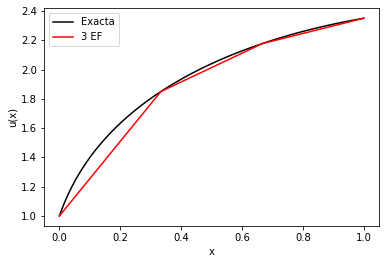

In [ ]:
# Solución exacta.
xx = np.linspace(0, L, 100)
ux = lambda x : (-6*x**2 + 18*x + 1)**(1/3)

plt.figure()
plt.plot(xx, ux(xx), "k-", label="Exacta")
plt.plot(xnod, d_i, "r-", label="3 EF")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.show()